<a href="https://colab.research.google.com/github/rajy4683/EVAP2/blob/master/END_NoCodeR_SelfTokenize_StableState.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Mar 10 16:06:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import pandas as pd
import numpy as np
import fileinput
import re
import itertools
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
#import seaborn as sns
import dateutil.parser
import datetime
#from ipyfilechooser import FileChooser
import numpy as np
import os
import gzip
import dateutil.parser
from datetime import datetime
import sys
import glob
import matplotlib.dates as mdates
from datetime import timedelta
import ipywidgets as widgets
from IPython.display import display
import torch
import json
import random
import spacy
from pprint import pprint
import six
import sys, token, tokenize
import ast
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
import random
import math
import time
from torch.utils.data.distributed import DistributedSampler
#from tensorboardX import SummaryWriter
from tqdm import tqdm, trange
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
from torch.optim.lr_scheduler import ReduceLROnPlateau


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install transformers

     |████████████████████████████████| 1.9MB 10.8MB/s 
     |████████████████████████████████| 3.2MB 46.5MB/s 
     |████████████████████████████████| 890kB 44.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=e4e2251f0c93184cc71d44c6b202259a1327fb40572a0a1e6db193edda67153d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [5]:
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
import tokenize

In [6]:
%%bash
python -m spacy download en
python -m spacy download de

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp37-none-any.whl size=14907057 sha256=32433f781fd3dafcacb10b6857fc89b16e71fb49eff4c234ce2630f6bedee6e4
  Stored in directory: /tmp/pip-ephem-wheel-cache-1jvv7syg/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


In [7]:
!wget https://s3.amazonaws.com/code-search-net/CodeSearchNet/v2/python.zip
!wget -O gpt2_bpe_encoder.json https://dl.fbaipublicfiles.com/fairseq/gpt2_bpe/encoder.json

!unzip /content/python.zip
!cp /content/python/final/jsonl/train/python_train_0.jsonl.gz .
!gzip -d /content/python_train_0.jsonl.gz

!cp /content/drive/MyDrive/EVA4/END_Capstone/english_python_data.txt .
!cp /content/drive/MyDrive/EVA4/END_Capstone/english_python_cleaned.txt .
!cp /content/drive/MyDrive/EVA4/END_Capstone/end_capstone.csv .

--2021-03-10 16:08:03--  https://s3.amazonaws.com/code-search-net/CodeSearchNet/v2/python.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.230.109
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.230.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 940909997 (897M) [application/zip]
Saving to: ‘python.zip’

python.zip          100%[===================>] 897.32M  35.3MB/s    in 26s     

2021-03-10 16:08:29 (34.2 MB/s) - ‘python.zip’ saved [940909997/940909997]

--2021-03-10 16:08:30--  https://dl.fbaipublicfiles.com/fairseq/gpt2_bpe/encoder.json
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1042301 (1018K) [text/plain]
Saving to: ‘gpt2_bpe_encoder.json’

gpt2_bpe_encoder.js 100%[===================>]   1018K  1.26MB/s    in 0.8s    



In [8]:
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel
from transformers import AutoTokenizer, AutoModel


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
auto_tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
spacy_en = spacy.load('en')
def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]
#model = RobertaModel.from_pretrained("microsoft/codebert-base")
#model.to(device)

In [9]:
"""
    Removes docstrings and comments
"""
def remove_docstrings_comments(src_string, doc_string=None, debug=False):
    mod = []

    prev_toktype = token.INDENT
    first_line = None
    last_lineno = -1
    last_col = 0
    try:
        #tokgen = tokenize.generate_tokens(source.readline)
        tokgen = tokenize.generate_tokens(six.StringIO(src_string.rstrip()).readline)
        for toktype, ttext, (slineno, scol), (elineno, ecol), ltext in tokgen:
            if 0:   # Change to if 1 to see the tokens fly by.
                print("%10s %-14s %-20r %r" % (
                    tokenize.tok_name.get(toktype, toktype),
                    "%d.%d-%d.%d" % (slineno, scol, elineno, ecol),
                    ttext, ltext
                    ))
            if slineno > last_lineno:
                last_col = 0
            if scol > last_col:
                mod.append(" " * (scol - last_col))
            if toktype == token.STRING and prev_toktype == token.INDENT:
                # Docstring
                mod.append("#--")
            elif toktype == tokenize.COMMENT:
                # Comment
                mod.append("##")
            else:
                mod.append(ttext)
            prev_toktype = toktype
            last_col = ecol
            last_lineno = elineno
        return "".join(mod)
    except:
        print(doc_string)
        print(src_string )
        print(sys.exc_info())

### CodeSearchNet

In [ ]:
columns_long_list = ['repo', 'path', 'url', 'code', 
                     'code_tokens', 'docstring', 'docstring_tokens', 
                     'language', 'partition']

with open("/content/python_train_0.jsonl",'r') as f:
    pd.concat([pd.read_json(f, 
                            orient='records', 
                            lines=True)[columns_long_list] 
                        ], sort=False)

In [ ]:
with open("/content/python_train_0.jsonl",'r') as f:
    my_df=pd.read_json(f, 
                orient='records', 
                lines=True)

In [ ]:
my_df_copy = my_df.loc[:20000,['docstring', 'code']].copy()

In [ ]:
my_df_copy['docstring_len'] =my_df_copy['docstring'].apply(lambda x: len(x))
my_df_copy['code_len'] = my_df_copy['code'].apply(lambda x: len(x))
my_df_copy['cleaned_code'] = my_df_copy.apply(lambda x: remove_docstrings_comments(x.code, x.docstring), axis=1)
my_df_copy['cleaned_code_len'] = my_df_copy['cleaned_code'].apply(lambda x: len(x))

In [ ]:
my_df_copy[my_df_copy['cleaned_code_len'] <= 256].count()

docstring           5612
code                5612
docstring_len       5612
code_len            5612
cleaned_code        5612
cleaned_code_len    5612
dtype: int64

In [ ]:
with open("gpt2_bpe_encoder.json") as f:
    gpt2_bpe=json.load(f)

In [ ]:
my_df_copy

In [ ]:
nl_to_pl_df = nl_to_pl_df.append(my_df_copy,ignore_index=True)

### Create datasets and dataloaders

In [10]:
nl_to_pl_df = pd.read_csv('/content/end_capstone.csv')

In [11]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [12]:
print(nl_to_pl_df['code_len'].max(),nl_to_pl_df['code_len'].min())
print(nl_to_pl_df['docstring_len'].max(),nl_to_pl_df['docstring_len'].min())
nl_to_pl_df[nl_to_pl_df['code_len'] ==0]
nl_to_pl_df[(nl_to_pl_df['code_len'] > 256) & (nl_to_pl_df['code_len'] < 512)] 

2443 11
313 16


,docstring,code,docstring_len,code_len,cleaned_code,cleaned_code_len
5,# Write a program to check whether a number is...,num = 337\n\nif num > 1:\n for i in range(2...,60,311,num = 337\n\nif num > 1:\n for i in range(2...,308
7,# Write a program to find the factorial of a n...,num = 13\nfactorial = 1\n\nif num < 0:\n pr...,52,265,num = 13\nfactorial = 1\n\nif num < 0:\n pr...,262
53,# Write a function that takes in height(m) and...,"\ndef bmi(height: ""Meters"", weight: ""Kgs""):\n ...",98,450,"\ndef bmi(height: ""Meters"", weight: ""Kgs""):\n ...",447
62,# write a python program to sort dictionary it...,"dict1 = {'car': [7, 6, 3], \n 'bike': ...",50,262,"dict1 = {'car': [7, 6, 3], \n 'bike': ...",260
74,# write a python program to Get the maximum an...,"\nmy_dict = {'x':500, 'y':5874, 'z': 560}\n\nk...",78,276,"\nmy_dict = {'x':500, 'y':5874, 'z': 560}\n\nk...",274
...,...,...,...,...,...,...
4352,# Define a class named Shape and its subclass ...,\n\nclass Shape(object):\n def __init__(sel...,234,314,\n\nclass Shape(object):\n def __init__(sel...,312
4354,# Write a python program for a binary search f...,"import math\ndef bin_search(li, element):\n ...",171,390,"import math\ndef bin_search(li, element):\n ...",388
4359,# Write a python program to check if a number ...,"n = int(input(""Enter any number: ""))\nsum1 = 0...",67,261,"n = int(input(""Enter any number: ""))\nsum1 = 0...",259
4360,# Write a python program to Check if a Number ...,"sum1 = 0\nnum = int(input(""Enter a number:""))\...",65,347,"sum1 = 0\nnum = int(input(""Enter a number:""))\...",345


In [13]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    # if n_gpu > 0:
    #     torch.cuda.manual_seed_all(seed)
set_seed(0x1112233)

In [14]:
!cp -rf /content/drive/MyDrive/EVA4/END_Capstone/cubert .
!pip install -r /content/cubert/requirements.txt
sys.path.append("/content/cubert/")

     |████████████████████████████████| 71kB 5.6MB/s 
     |████████████████████████████████| 92kB 5.7MB/s 
     |████████████████████████████████| 1.5MB 16.2MB/s 
     |████████████████████████████████| 412.3MB 42kB/s 
     |████████████████████████████████| 194kB 38.8MB/s 
     |████████████████████████████████| 358kB 36.8MB/s 
     |████████████████████████████████| 983kB 35.6MB/s 
     |████████████████████████████████| 706kB 39.8MB/s 
     |████████████████████████████████| 368kB 35.2MB/s 
     |████████████████████████████████| 81kB 9.5MB/s 
     |████████████████████████████████| 368kB 40.9MB/s 
     |████████████████████████████████| 655kB 41.3MB/s 
     |████████████████████████████████| 5.6MB 38.3MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
     |████████████████████████████████| 512kB 40.3MB/s 
     |████████████████████████████████| 3.8MB 37.9MB/s 
     |████████████████████████████████| 163kB 37.8MB/s 
     |████████████████████████████████| 245kB 44.3MB/s 


In [15]:
"""A Python tokenizer subclass of CuBertTokenizer."""
import keyword
import re
import tokenize
import typing
from typing import Any
from typing import List
from typing import Sequence
from typing import Tuple
from absl import logging
from cubert import cubert_tokenizer
from cubert import unified_tokenizer


class PythonTokenizer2(cubert_tokenizer.CuBertTokenizer):
  """Tokenizer that extracts Python's lexical elements preserving strings."""
  _TOKEN_TYPE_MAP = {
      tokenize.COMMENT: unified_tokenizer.TokenKind.COMMENT,
      tokenize.DEDENT: unified_tokenizer.TokenKind.KEYWORD,
      tokenize.ENDMARKER: unified_tokenizer.TokenKind.EOS,
      tokenize.ERRORTOKEN: unified_tokenizer.TokenKind.ERROR,
      tokenize.INDENT: unified_tokenizer.TokenKind.KEYWORD,
      tokenize.NEWLINE: unified_tokenizer.TokenKind.NEWLINE,
      tokenize.NL: unified_tokenizer.TokenKind.PUNCTUATION,
      tokenize.NUMBER: unified_tokenizer.TokenKind.NUMBER,
      tokenize.OP: unified_tokenizer.TokenKind.PUNCTUATION,
      tokenize.STRING: unified_tokenizer.TokenKind.STRING,
  }
  _REVERSE_TOKEN_MAP = {
      cubert_tokenizer.token_from_token_type(tokenize.INDENT):
          tokenize.INDENT,
      cubert_tokenizer.token_from_token_type(tokenize.DEDENT):
          tokenize.DEDENT,
      unified_tokenizer.quote_special(unified_tokenizer.TokenKind.EOS.name):
          tokenize.ENDMARKER,
      unified_tokenizer.quote_special(unified_tokenizer.TokenKind.ERROR.name):
          tokenize.ERRORTOKEN,
      unified_tokenizer.quote_special(unified_tokenizer.TokenKind.NEWLINE.name):
          tokenize.NEWLINE,
      cubert_tokenizer.token_from_token_type(tokenize.NL):
          tokenize.NL,
  }
  # Adding the end-of-string anchor \Z below, since re.fullmatch wasn't
  # available in Python2.
  _NUMBERS = re.compile('(' + tokenize.Number + r')\Z')  # pytype: disable=module-attr
  _SINGLE_STRINGS = re.compile('(' + tokenize.String + r')\Z')  # pytype: disable=module-attr
  _TRIPLE_STRING_BEGINNINGS = re.compile(tokenize.Triple)  # pytype: disable=module-attr
  _COMMENTS = re.compile('(' + tokenize.Comment + r')\Z')  # pytype: disable=module-attr

  _EXACT_TOKEN_TYPES = tokenize.EXACT_TOKEN_TYPES.keys()  # pytype: disable=module-attr

  # Token types that CubertTokenizer will tokenize by their type and not
  # content.
  _TOKEN_TYPES_TO_TOKENIZE_BY_TYPE = [
      tokenize.NEWLINE, tokenize.DEDENT, tokenize.NL
  ]

  def tokenize_and_abstract(
      self,
      source_code):
    """Produces a language-agnostic tokenization of the input code."""
    agnostic_tokens: List[unified_tokenizer.AbstractToken] = []

    try:
      token_tuples = unified_tokenizer.code_to_tokens(source_code)
    except (tokenize.TokenError, IndentationError) as e:
      logging.warning('The tokenizer raised exception `%s` while parsing %s', e,
                      source_code)

      # We don't try to do recovery from errors quite yet. Emit just an
      # error and end-of-sequence and return.
      agnostic_tokens.append(
          unified_tokenizer.AbstractToken(
              unified_tokenizer.quote_special(
                  unified_tokenizer.TokenKind.ERROR.name),
              unified_tokenizer.TokenKind.ERROR,
              unified_tokenizer.TokenMetadata(
                  start=unified_tokenizer.Position(
                      line=0, column=0),
                  end=unified_tokenizer.Position(
                      line=0, column=0))))
      agnostic_tokens.append(
          unified_tokenizer.AbstractToken(
              unified_tokenizer.quote_special(
                  unified_tokenizer.TokenKind.EOS.name),
              unified_tokenizer.TokenKind.EOS,
              unified_tokenizer.TokenMetadata(
                  start=unified_tokenizer.Position(
                      line=0, column=0),
                  end=unified_tokenizer.Position(
                      line=0, column=0))))
      return agnostic_tokens

    for token_tuple in token_tuples:
      spelling = token_tuple.string
      kind = token_tuple.type

      # We'll adjust the spelling of some tokens, e.g., those that we
      # tokenize by their type rather than their original spelling. Indentation
      # and dedentation tokens are like that.
      adjusted_spelling = spelling
      token_kind = unified_tokenizer.TokenKind.NONE
      if kind == tokenize.NAME:
        # Disambiguate identifiers from keywords.
        if keyword.iskeyword(spelling):
          token_kind = unified_tokenizer.TokenKind.KEYWORD
        else:
          token_kind = unified_tokenizer.TokenKind.IDENTIFIER
      else:
        if kind in PythonTokenizer2._TOKEN_TYPES_TO_TOKENIZE_BY_TYPE:
          # Replace spelling with type.
          adjusted_spelling = cubert_tokenizer.token_from_token_type(kind)
        elif kind is tokenize.INDENT:
          # For INDENT, in particular, we also record the actual spelling too.
          adjusted_spelling = '{indent}{spelling}'.format(
              indent=cubert_tokenizer.token_from_token_type(kind),
              spelling=spelling)
          #print(adjusted_spelling)
        elif kind == tokenize.ENDMARKER:
          adjusted_spelling = unified_tokenizer.quote_special(
              unified_tokenizer.TokenKind.EOS.name)

        # Map everything according to table.
        try:
          token_kind = PythonTokenizer2._TOKEN_TYPE_MAP[kind]
        except KeyError as ke:
          # It's possible we're here because of async/await. Those kept being
          # turned into keywords and then removed from keywords, so we can't
          # rely on knowing which they are. We'll check by spelling.
          # See: https://bugs.python.org/issue30406
          # and https://bugs.python.org/issue33260
          # and https://bugs.python.org/issue35975
          if spelling in ('async', 'await'):
            token_kind = unified_tokenizer.TokenKind.KEYWORD
          else:
            raise ValueError('While trying to turn Python token %r into an '
                             'agnostic one, raised %r.' %
                             ((spelling, kind), ke))

      start_line, start_column = token_tuple.start
      end_line, end_column = token_tuple.end
      # Unlike other languages, NEWLINE tokens are reported as ending on the
      # same line as where they started. We adjust that here, to stick to the
      # same convention as other tokenizers.
      if ((token_kind == unified_tokenizer.TokenKind.NEWLINE) or
          (kind == tokenize.NL)):
        end_line = start_line + 1
        end_column = 0

      agnostic_tokens.append(
          unified_tokenizer.AbstractToken(
              spelling=adjusted_spelling, kind=token_kind,
              metadata=unified_tokenizer.TokenMetadata(
                  # Python's tokenizer counts lines starting from 1, so we
                  # have to offset what we read from the `TokenInfo` tuple.
                  start=unified_tokenizer.Position(
                      line=start_line - 1, column=start_column),
                  end=unified_tokenizer.Position(
                      line=end_line - 1, column=end_column))))
    #print(agnostic_tokens)
    return agnostic_tokens

  def untokenize_abstract(self, whole_tokens):
    # Reconstruct Python tokenizer tuples, so that Python's untokenize can be
    # invoked.
    token_tuples: List[Tuple[int, str]] = []

    for whole_token in whole_tokens:
      if whole_token in PythonTokenizer2._EXACT_TOKEN_TYPES:
        token_tuples.append((tokenize.OP, whole_token))
      elif cubert_tokenizer.token_from_token_type(
          tokenize.INDENT) in whole_token:
        # We baked the type and spelling into one token. Break them up.
        spelling = whole_token.replace(
            cubert_tokenizer.token_from_token_type(tokenize.INDENT), '')
        token_tuples.append((tokenize.INDENT, spelling))
      elif whole_token in PythonTokenizer2._REVERSE_TOKEN_MAP:
        python_kind = PythonTokenizer2._REVERSE_TOKEN_MAP[whole_token]
        if python_kind in (tokenize.DEDENT, tokenize.ENDMARKER,
                           tokenize.ERRORTOKEN):
          spelling = ''
        else:  # python_kind in (tokenize.NEWLINE, tokenize.NL)
          spelling = '\n'
        token_tuples.append((python_kind, spelling))
      elif keyword.iskeyword(whole_token):
        token_tuples.append((tokenize.NAME, whole_token))
      elif PythonTokenizer2._NUMBERS.match(whole_token):
        token_tuples.append((tokenize.NUMBER, whole_token))
      elif PythonTokenizer2._SINGLE_STRINGS.match(whole_token):
        token_tuples.append((tokenize.STRING, whole_token))
      elif PythonTokenizer2._TRIPLE_STRING_BEGINNINGS.match(whole_token):
        token_tuples.append((tokenize.STRING, whole_token))
      elif PythonTokenizer2._COMMENTS.match(whole_token):
        token_tuples.append((tokenize.COMMENT, whole_token))
      else:
        # Everything else we map back to NAME.
        token_tuples.append((tokenize.NAME, whole_token))

    reconstructed = tokenize.untokenize(typing.cast(Any, token_tuples))
    return reconstructed



In [16]:
def get_lang_specific_tokens(init_tokenizer, code_snip):
    #tokens_complete = init_tokenizer.tokenize(source_code=code_snip)
    tokens = init_tokenizer.tokenize_and_abstract(source_code=code_snip )
    conditioned = init_tokenizer.condition_full_tokens(tokens)
    agnostic_token_lists = unified_tokenizer._agnostic_tokens_to_lists_of_token_lists(conditioned)
    with_identifiers_heuristically_split = unified_tokenizer._subtokenize_identifiers_heuristically(
        agnostic_token_lists)
    with_string_tokens_heuristically_split = unified_tokenizer._subtokenize_strings_heuristically(
        with_identifiers_heuristically_split)
    shortened_subtokens = unified_tokenizer._shorten_subtokens(with_string_tokens_heuristically_split, 20)
    sanitization_mapping = init_tokenizer.get_mappings()
    subtoken_lists = unified_tokenizer.sanitize_subtoken_lists(shortened_subtokens,
                                            sanitization_mapping,
                                            unified_tokenizer.SENTINEL)
    #flat_toks =unified_tokenizer.flatten_subtoken_lists(subtoken_lists)
    test_spellings = []
    test_tok_types = []
    for t in subtoken_lists:
        #if(len(t.spelling) == 1):
        #print(len(t.spellings))
        test_spellings.extend(t.spellings)
        match=False
        for cubert_token in set(init_tokenizer._REVERSE_TOKEN_MAP.keys()):
            #print("Checking for:",cubert_token)
            if cubert_token in t.spellings[0]:
                #print(t.spellings)
                selected_token = tokenize.tok_name[init_tokenizer._REVERSE_TOKEN_MAP[cubert_token]]
                test_tok_types.extend([selected_token]*len(t.spellings))
                match=True          
        if match == False:
            test_tok_types.extend([t.kind.name]*len(t.spellings))
    return test_spellings, test_tok_types



In [17]:
class NewVectorizer():
    def __init__(self, code_piece, tok_type_counter):
        self.code_piece = code_piece
        self.tok_type_counter = tok_type_counter
        self.code_word2idx = {'<s>':0,'</s>':1,'<pad>':2, '<unk>':3}
        self.code_idx2word = {v:k for k,v in self.code_word2idx.items()}
        self.toktype_word2idx = {'<s>':0,'</s>':1,'<pad>':2, '<unk>':3}
        self.toktype_idx2word = {v:k for k,v in self.toktype_word2idx.items()}
        self.max_tok_length = len(self.toktype_word2idx)
        self.max_code_length = len(self.code_word2idx)
        self.UNK_FOR_TOKEN_TYPE = '<unk>'
        self.UNK_FOR_CODEPIECE = '<unk>'
        self.ID_UNK_TOKEN_TYPE = self.toktype_word2idx[self.UNK_FOR_TOKEN_TYPE]
        self.ID_UNK_CODEPIECE = self.code_word2idx[self.UNK_FOR_CODEPIECE]

        self.PAD_FOR_CODEPIECE = '<pad>'
        self.PAD_FOR_TOKEN_TYPE = '<pad>'
        self.ID_PAD_FOR_CODEPIECE = self.code_word2idx['<pad>']
        self.ID_PAD_FOR_TOKEN_TYPE = self.toktype_word2idx['<pad>']
        
        self.SOS_FOR_CODEPIECE = '<s>'
        self.SOS_FOR_TOKEN_TYPE = '<s>'
        self.ID_SOS_FOR_CODEPIECE = self.code_word2idx['<s>']
        self.ID_SOS_FOR_TOKEN_TYPE = self.toktype_word2idx['<s>']

        self.EOS_FOR_CODEPIECE = '</s>'
        self.EOS_FOR_TOKEN_TYPE = '</s>'
        self.ID_EOS_FOR_CODEPIECE = self.code_word2idx['</s>']
        self.ID_EOS_FOR_TOKEN_TYPE = self.toktype_word2idx['</s>']
        self.build_vocab()

    def build_vocab(self):
        idx=len(self.code_word2idx.keys())
        for k in self.code_piece.keys():
            self.code_word2idx[k]=idx
            self.code_idx2word[idx]=k
            idx += 1
        
        idx=len(self.toktype_word2idx.keys())
        for k in self.tok_type_counter.keys():
            self.toktype_word2idx[k]=idx
            self.toktype_idx2word[idx]=k
            idx += 1

        self.max_tok_length = len(self.toktype_word2idx.keys())
        self.max_code_length = len(self.code_word2idx.keys())
    ### Returns the code piece for a given ID
    def convert_id_to_codepiece(self, id_for_code):
        if(id_for_code not in list(self.code_idx2word.keys())):
            return self.UNK_FOR_CODEPIECE
        return self.code_idx2word[id_for_code]
    ### Returns the ID for a given code piece
    def convert_codepiece_to_id(self, code_piece):
        if(code_piece not in list(self.code_word2idx.keys())):
            return self.ID_UNK_CODEPIECE
        return self.code_word2idx[code_piece]
    ### Returns the TOKEN ID for a given TOKEN type
    def convert_toktype_to_id(self, tok_piece):
        if(tok_piece not in list(self.toktype_word2idx.keys())):
            print("No match for",tok_piece)
            return self.ID_UNK_TOKEN_TYPE
        return self.toktype_word2idx[tok_piece]
    ### Returns the TOKEN type for a given TOKEN ID
    def convert_id_to_toktype(self, id_for_toktype):
        if(id_for_toktype not in list(self.toktype_idx2word.keys())):
            return self.UNK_FOR_TOKEN_TYPE
        return self.toktype_idx2word[id_for_toktype]

In [18]:
import cubert
from absl import app
from absl import flags
from tensor2tensor.data_generators import text_encoder
import enum
import cubert_tokenizer
from cubert import code_to_subtokenized_sentences
#from cubert import tokenizer_registry
from cubert import python_tokenizer
import python_tokenizer
from tensor2tensor.data_generators import text_encoder_build_subword
from collections import Counter, defaultdict

@enum.unique
class TokenizerEnum(enum.Enum):
  """Enum for Tokenizers."""
  #PYTHON = python_tokenizer.PythonTokenizer
  PYTHON = PythonTokenizer2

In [19]:
#### Generate and create the Vectorizer instance
word_counter=Counter()
init_tokenizer=PythonTokenizer2()
tok_type_counter = Counter()
for code_snip in nl_to_pl_df['cleaned_code']:
    toks, tok_types = get_lang_specific_tokens(init_tokenizer, code_snip)
    word_counter.update(Counter(toks))
    tok_type_counter.update(Counter(tok_types))

In [20]:
code_tok_vectorizer = NewVectorizer(word_counter, tok_type_counter)
print(code_tok_vectorizer.max_code_length,code_tok_vectorizer.max_tok_length)

5813 16


In [ ]:
tok_type_ids = [ code_tok_vectorizer.convert_toktype_to_id(toktype) for toktype in tok_types]

In [ ]:
[ code_tok_vectorizer.convert_id_to_toktype(toktype) for toktype in tok_type_ids] == tok_types

True

### Old NLP DS

In [21]:
tok_ids_list=[]
class NLPLSingleEntry(object):
    """A single set of features of data."""

    def __init__(self, 
                 code_ids, 
                 code_mask, 
                 doc_ids,
                 doc_mask,
                 ):
        self.code_ids = code_ids
        self.code_mask = code_mask
        self.doc_ids = doc_ids
        self.doc_mask = doc_mask
        #self.segment_ids = segment_ids
        #self.label_id = label_id
class NLPLDataSet():
    def __init__(self, 
                 doc_tokenizer, 
                 code_tokenizer):
        self.doc_tokenizer = doc_tokenizer
        self.code_tokenizer = code_tokenizer

    def prepare_tokens(self, 
                       samples, 
                       tokenizer, 
                       max_seq_length=0,
                       data_type=None):
        """
            Tokenizes an input sequence, adds padding and SOS+EOS 
        """
        toks = tokenizer.tokenize(samples)
        # print(data_type)
        # print(toks)
        if max_seq_length > 2 and len(toks) > max_seq_length - 2:
            toks = toks[:max_seq_length -2]
        tok_ids =  tokenizer.convert_tokens_to_ids(toks)
        ### We use pseudo-BERT process so we will add both CLS and SEP tokens for
        ### src and target inputs
        tok_ids = [tokenizer.cls_token_id] + tok_ids + [tokenizer.sep_token_id]
        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [ 1 ] * len(tok_ids)

        if len(tok_ids) < max_seq_length:
            padding_length = max_seq_length - len(tok_ids)
            tok_ids = tok_ids + ([tokenizer.pad_token_id] * padding_length)
            input_mask = input_mask + ([ 0 ] * padding_length) ### Padded tokens are zero-masked
        
        # print(tok_ids)
        return tok_ids, input_mask

    def create_dataset(self,
                    nl_to_pl_df,
                    final_ds,
                    sample_count=10000,
                    max_doc_len=50,
                    max_code_len=0):
        """
            Reads from a dataframe, tokenizes and numericalizes both docstrings 
            and code. 

        """
        #final_ds = []
        for idx in nl_to_pl_df.itertuples():
            ## For SOS and EOS tokens 2 positions are left
            if not idx.cleaned_code:
                print("Invalid entry, No code found for:", idx.docstring)
            
            doc_toks, doc_mask = self.prepare_tokens(idx.docstring,
                                                      self.doc_tokenizer,
                                                      max_doc_len,
                                                      "docs")
            code_toks, code_mask = self.prepare_tokens(idx.cleaned_code,
                                                      self.code_tokenizer,
                                                      max_code_len,
                                                      "code")
            #code_toks = None
            ### Skip over current iteration if no valid code found

            # print(code_toks)
            # print(code_mask)
            # print(doc_toks)
            # print(doc_mask)
            final_entry = NLPLSingleEntry(code_toks, 
                                            code_mask, 
                                            doc_toks, 
                                            doc_mask)
            # print(final_entry.code_ids)
            # print(final_entry.code_mask)
            # print(final_entry.doc_ids)
            # print(final_entry.doc_mask)
            final_ds.append(final_entry)
        #print(len(final_ds))
        return final_ds
        

### New NLP DS

In [22]:
tok_ids_list=[]
class NLPLSingleEntry(object):
    """A single set of features of data."""

    def __init__(self, 
                 code_ids,
                 tok_ids,
                 code_mask, 
                 doc_ids,
                 doc_mask,
                 ):
        self.code_ids = code_ids
        self.code_mask = code_mask
        self.tok_ids = tok_ids
        self.doc_ids = doc_ids
        self.doc_mask = doc_mask
        #self.segment_ids = segment_ids
        #self.label_id = label_id
class NLPLDataSet():
    def __init__(self, 
                 doc_tokenizer, 
                 code_tokenizer,
                 code_tok_vectorizer):
        self.doc_tokenizer = doc_tokenizer
        self.code_tokenizer = code_tokenizer
        self.code_tok_vectorizer = code_tok_vectorizer

    def prepare_tokens(self, 
                       samples, 
                       tokenizer, 
                       max_seq_length=0,
                       data_type=None):
        """
            Tokenizes an input sequence, adds padding and SOS+EOS 
        """
        toks = tokenizer.tokenize(samples)
        # print(data_type)
        # print(toks)
        if max_seq_length > 2 and len(toks) > max_seq_length - 2:
            toks = toks[:max_seq_length -2]
        tok_ids =  tokenizer.convert_tokens_to_ids(toks)
        ### We use pseudo-BERT process so we will add both CLS and SEP tokens for
        ### src and target inputs
        tok_ids = [tokenizer.cls_token_id] + tok_ids + [tokenizer.sep_token_id]
        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [ 1 ] * len(tok_ids)

        if len(tok_ids) < max_seq_length:
            padding_length = max_seq_length - len(tok_ids)
            tok_ids = tok_ids + ([tokenizer.pad_token_id] * padding_length)
            input_mask = input_mask + ([ 0 ] * padding_length) ### Padded tokens are zero-masked
        
        # print(tok_ids)
        return tok_ids, input_mask
    def prepare_code_tokens(self, 
                       samples, 
                       tokenizer, 
                       max_seq_length=0,
                       data_type=None):
        """
            Tokenizes an input sequence, adds padding and SOS+EOS 
        """
        _toks, _tok_types = get_lang_specific_tokens(self.code_tokenizer, samples)
        #print(_tok_types)
        # print(data_type)
        # print(toks)
        if max_seq_length > 2 and len(_toks) > max_seq_length - 2:
            _toks = _toks[:max_seq_length -2]
            _tok_types = _tok_types[:max_seq_length -2]
        #tok_ids =  tokenizer.convert_tokens_to_ids(toks)
        tok_ids = [ self.code_tok_vectorizer.convert_codepiece_to_id(code) for code in _toks]
        tok_types = [ self.code_tok_vectorizer.convert_toktype_to_id(toktype) for toktype in _tok_types]
        
        ### We use pseudo-BERT process so we will add both CLS and SEP tokens for
        ### src and target inputs
        tok_ids = [self.code_tok_vectorizer.ID_SOS_FOR_CODEPIECE] + tok_ids + [self.code_tok_vectorizer.ID_EOS_FOR_CODEPIECE]
        tok_types = [self.code_tok_vectorizer.ID_SOS_FOR_TOKEN_TYPE] + tok_types + [self.code_tok_vectorizer.ID_EOS_FOR_TOKEN_TYPE]
        #print(len(tok_ids), len(tok_types))
        assert(len(tok_ids) == len(tok_types))
        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [ 1 ] * len(tok_ids)

        if len(tok_ids) < max_seq_length:
            padding_length = max_seq_length - len(tok_ids)
            tok_ids = tok_ids + ([self.code_tok_vectorizer.ID_PAD_FOR_CODEPIECE] * padding_length)
            tok_types = tok_types + ([self.code_tok_vectorizer.ID_PAD_FOR_TOKEN_TYPE] * padding_length)
            input_mask = input_mask + ([ 0 ] * padding_length) ### Padded tokens are zero-masked
        
        # print(tok_ids)
        return tok_ids, tok_types, input_mask

    def create_dataset(self,
                    nl_to_pl_df,
                    final_ds,
                    sample_count=10000,
                    max_doc_len=50,
                    max_code_len=0):
        """
            Reads from a dataframe, tokenizes and numericalizes both docstrings 
            and code. 

        """
        #final_ds = []
        for idx in nl_to_pl_df.itertuples():
            ## For SOS and EOS tokens 2 positions are left
            if not idx.cleaned_code:
                print("Invalid entry, No code found for:", idx.docstring)
            
            doc_toks, doc_mask = self.prepare_tokens(idx.docstring,
                                                      self.doc_tokenizer,
                                                      max_doc_len,
                                                      "docs")
            code_ids, tok_ids, code_mask = self.prepare_code_tokens(idx.cleaned_code,
                                                      self.code_tokenizer,
                                                      max_code_len,
                                                      "code")
            #code_toks = None
            ### Skip over current iteration if no valid code found

            # print(code_toks)
            # print(code_mask)
            # print(doc_toks)
            # print(doc_mask)
            final_entry = NLPLSingleEntry(code_ids,
                                          tok_ids,
                                          code_mask, 
                                          doc_toks, 
                                          doc_mask)
            # print(final_entry.code_ids)
            # print(final_entry.code_mask)
            # print(final_entry.doc_ids)
            # print(final_entry.doc_mask)
            final_ds.append(final_entry)
        #print(len(final_ds))
        return final_ds
        

In [23]:
### We will use the same tokenizer for both docstrings and code
final_ds = []
MAX_LENGTH=512
#selected_elems = nl_to_pl_df[nl_to_pl_df['cleaned_code_len'] <= MAX_LENGTH]
#selected_elems = my_df_copy[my_df_copy['code_len'] <= MAX_LENGTH]
MAX_VOCAB_LENGTH=256
assert(MAX_VOCAB_LENGTH <= MAX_LENGTH)
#selected_elems = nl_to_pl_df[nl_to_pl_df['cleaned_code_len'] <= MAX_LENGTH]
#selected_elems = my_df_copy[my_df_copy['code_len'] <= MAX_LENGTH]
init_tokenizer=PythonTokenizer2()
#selected_elems = nl_to_pl_df[nl_to_pl_df['cleaned_code_len'] <= MAX_VOCAB_LENGTH]

selected_elems = nl_to_pl_df[(nl_to_pl_df['cleaned_code_len'] <= MAX_VOCAB_LENGTH) & (nl_to_pl_df['docstring_len'] <= MAX_VOCAB_LENGTH*2)]
my_nlpl_ds = NLPLDataSet(auto_tokenizer, init_tokenizer, code_tok_vectorizer).create_dataset(selected_elems, 
                                                                        final_ds, 
                                                                        max_doc_len=MAX_VOCAB_LENGTH, 
                                                                        max_code_len=MAX_VOCAB_LENGTH)


In [ ]:
selected_elems.count

In [24]:
all_code_ids = torch.tensor([f.code_ids for f in my_nlpl_ds], dtype=torch.long)
all_code_mask = torch.tensor([f.code_mask for f in my_nlpl_ds], dtype=torch.long)
all_doc_ids = torch.tensor([f.doc_ids for f in my_nlpl_ds], dtype=torch.long)
all_doc_mask = torch.tensor([f.doc_mask for f in my_nlpl_ds], dtype=torch.long)
all_tok_ids = torch.tensor([f.tok_ids for f in my_nlpl_ds], dtype=torch.long)
# if output_mode == "classification":
#     all_label_ids = torch.tensor([f.label_id for f in my_nlpl_ds], dtype=torch.long)

train_dataset = TensorDataset(all_code_ids,
                              all_code_mask, 
                              all_doc_ids, 
                              all_doc_mask,
                              all_tok_ids)




In [25]:
dataset_size = len(train_dataset)
dataset_indices = list(range(dataset_size))
np.random.shuffle(dataset_indices)
val_split_index = int(np.floor(0.2 * dataset_size))

train_idx, val_idx = dataset_indices[val_split_index:], dataset_indices[:val_split_index]

In [26]:
BATCH_SIZE=8
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)


#train_sampler = RandomSampler(train_dataset,) #if args.local_rank == -1 else DistributedSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE, shuffle=False)
val_dataloader = DataLoader(train_dataset, sampler=val_sampler, batch_size=BATCH_SIZE, shuffle=False)

#train_sampler = RandomSampler(train_dataset) #if args.local_rank == -1 else DistributedSampler(train_dataset)

train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

In [ ]:
iter_one = next(iter(train_dataloader))
iter_one_val = next(iter(val_dataloader))

#iter_one[0]=all_code_ids, 
#iter_one[1]=all_code_mask, 
#iter_one[2]=all_doc_ids, 
#iter_one[3]=all_doc_mask
#mask_reshape.shape
# trg = iter_one[0]
# trg_len = trg.shape[1]
# trg_pad_mask = iter_one[1].unsqueeze(1).unsqueeze(2) 
# trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len))).bool()

# #trg_sub_mask = [trg len, trg len]
    
# trg_mask = trg_pad_mask & trg_sub_mask

In [ ]:
iter_one[-1].shape

torch.Size([8, 128])

### Model Definitions

In [27]:
class TransEncoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 1000):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([TransEncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

In [28]:
class TransEncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

In [29]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [30]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

In [31]:
class TransDecoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 1000,
                 tok_type_dim=62):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.tok_type_embedding = nn.Embedding(tok_type_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([TransDecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.fc_out_tok = nn.Linear(hid_dim, tok_type_dim)
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask, src_tok_types):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + 
                           self.pos_embedding(pos) + 
                           self.tok_type_embedding(src_tok_types))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        output_tok = self.fc_out_tok(trg)
        #output =F.softmax(output, dim=2)  
        
        #output = [batch size, trg len, output dim]
            
        return output, output_tok, attention

In [32]:
class TransDecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        # query, key, value
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

In [33]:
class TransSeq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device,
                 ):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src_mask):
        
        #src = [batch size, src len]
        
        src_mask = src_mask.unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg, trg_mask):
        
        #trg = [batch size, trg len]
        trg_pad_mask = trg_mask.unsqueeze(1).unsqueeze(2) 
        """
            A boolean tensor of shape [batch size, 1, 1, trg len]
        """
        
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, src_mask, trg, trg_mask, src_tok_types):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src_mask)
        trg_mask = self.make_trg_mask(trg, trg_mask)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, tok_output, attention = self.decoder(trg, 
                                         enc_src, 
                                         trg_mask, 
                                         src_mask, 
                                         src_tok_types)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, tok_output, attention

In [34]:
INPUT_DIM = auto_tokenizer.vocab_size
OUTPUT_DIM = code_tok_vectorizer.max_code_length
TOK_TYPE_OUTPUT_DIM = code_tok_vectorizer.max_tok_length
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 1024
DEC_PF_DIM = 1024
ENC_DROPOUT = 0.2
DEC_DROPOUT = 0.2

enc = TransEncoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device,
              max_length=MAX_LENGTH)

dec = TransDecoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device,
              max_length=MAX_LENGTH,
              tok_type_dim=TOK_TYPE_OUTPUT_DIM)

In [ ]:
code_tok_vectorizer.max_tok_length

16

In [ ]:
# INPUT_DIM = auto_tokenizer.vocab_size
# OUTPUT_DIM = auto_tokenizer.vocab_size
# HID_DIM = 256
# ENC_LAYERS = 3
# DEC_LAYERS = 3
# ENC_HEADS = 8
# DEC_HEADS = 8
# ENC_PF_DIM = 1024
# DEC_PF_DIM = 1024
# ENC_DROPOUT = 0.2
# DEC_DROPOUT = 0.2

# enc = TransEncoder(INPUT_DIM, 
#               HID_DIM, 
#               ENC_LAYERS, 
#               ENC_HEADS, 
#               ENC_PF_DIM, 
#               ENC_DROPOUT, 
#               device)

# dec = TransDecoder(OUTPUT_DIM, 
#               HID_DIM, 
#               DEC_LAYERS, 
#               DEC_HEADS, 
#               DEC_PF_DIM, 
#               DEC_DROPOUT, 
#               device,
#               max_length=MAX_LENGTH)

In [ ]:
MAX_LENGTH

256

In [ ]:
!nvidia-smi

In [ ]:
!cp /content/drive/MyDrive/EVA4/END_Capstone/end_capstone_baseline_128.pt .

In [35]:
SRC_PAD_IDX = auto_tokenizer.pad_token_id #SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = code_tok_vectorizer.ID_PAD_FOR_TOKEN_TYPE #TRG.vocab.stoi[TRG.pad_token]

model = TransSeq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [ ]:
model

In [36]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)


In [37]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 21,649,861 trainable parameters


In [38]:
model.apply(initialize_weights);
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [ ]:
iter_one = next(iter(train_dataloader))
batch = tuple(t.to(device) for t in iter_one)
# inputs = {'input_ids': batch[0],
#             'attention_mask': batch[1],
#             'token_type_ids': batch[2] ,
#             # XLM don't use segment_ids
#             'labels': batch[3]}

In [39]:
def train(model, iterator, optimizer, criterion, clip, device,double_loss=False):
    
    model.train()
    
    epoch_loss = 0
    epoch_crit_loss = 0
    epoch_tok_loss = 0
    
    for i, batch in enumerate(iterator):
        
        trg = batch[0].to(device)
        trg_mask = batch[1].to(device)
        src = batch[2].to(device)
        src_mask = batch[3].to(device)
        src_tok_type = batch[4].to(device)
        
        optimizer.zero_grad()
        
        output, tok_op, _ = model(src, src_mask, trg[:,:-1], trg_mask[:,:-1], src_tok_type[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
        if(double_loss == True):            
            tok_op_output_dim = tok_op.shape[-1]            
            tok_op = tok_op.contiguous().view(-1, tok_op_output_dim)
            src_tok_type = src_tok_type[:,1:].contiguous().view(-1)
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]            
            loss,crit_loss, tok_loss = criterion(output, 
                                                 trg,
                                                 tok_op,
                                                 src_tok_type)
            epoch_crit_loss += crit_loss.item()
            epoch_tok_loss += tok_loss.item()
        else:
            loss = criterion(output, trg)
            
        loss.backward()        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()        
        epoch_loss += loss.item()
    
    if(double_loss == True):  
        print(f'Train\tCrit Loss: {epoch_crit_loss/(len(iterator)):.3f} | Token Loss: {epoch_tok_loss/(len(iterator)):.3f}')

    return epoch_loss / len(iterator)

In [40]:
def evaluate(model, iterator, criterion, device,double_loss=False):
    
    model.eval()
    
    epoch_loss = 0
    epoch_crit_loss = 0
    epoch_tok_loss = 0
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            trg = batch[0].to(device)
            trg_mask = batch[1].to(device)
            src = batch[2].to(device)
            src_mask = batch[3].to(device)
            src_tok_type = batch[4].to(device)

            #output, _ = model(src, src_mask, trg[:,:-1], trg_mask[:,:-1])
            output, tok_op, _ = model(src, src_mask, trg[:,:-1], trg_mask[:,:-1], src_tok_type[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            if(double_loss == True):            
                tok_op_output_dim = tok_op.shape[-1]            
                tok_op = tok_op.contiguous().view(-1, tok_op_output_dim)
                src_tok_type = src_tok_type[:,1:].contiguous().view(-1)
                #output = [batch size * trg len - 1, output dim]
                #trg = [batch size * trg len - 1]            
                loss,crit_loss, tok_loss = criterion(output, 
                                                     trg,
                                                     tok_op,
                                                     src_tok_type)
                epoch_crit_loss += crit_loss.item()
                epoch_tok_loss += tok_loss.item()
            else:
                loss = criterion(output, trg)
            

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            # loss = criterion(output, 
            #                  trg,
            #                  tok_op,
            #                  src_tok_type)

            epoch_loss += loss.item()

    if(double_loss == True):  
        print(f'Val\tCrit Loss: {epoch_crit_loss/(len(iterator)):.3f} | Token Loss: {epoch_tok_loss/(len(iterator)):.3f}')  
    return epoch_loss / len(iterator)

In [41]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [42]:
# my_torch_weights = torch.ones(auto_tokenizer.vocab_size)
# my_torch_weights[1437] = 2
# criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX, weight=my_torch_weights.to(device) )

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

class WeightedCrossEntropy(nn.Module):
    def __init__(self,
                 code_weights=None,
                 code_ignore_idx=None,
                 tok_type_weights=None,
                 tok_type_ignore_idx=None,
                 mix_ratio=0.5):
        
        super(WeightedCrossEntropy, self).__init__()
        self.code_weights=code_weights
        self.code_ignore_idx=code_ignore_idx
        self.tok_type_weights=tok_type_weights
        self.tok_type_ignore_idx=tok_type_ignore_idx
        self.mix_ratio = mix_ratio
    
    def forward(self, 
                code_output, 
                code_trg,
                tok_type_output,
                tok_type_trg):
        
        # code_criterion = nn.CrossEntropyLoss(ignore_index = self.code_ignore_idx,
        #                                      weight=self.code_weights)
        # toktype_criterion = nn.CrossEntropyLoss(ignore_index = self.tok_type_ignore_idx,
        #                                 weight=self.tok_type_weights)

        code_criterion = F.cross_entropy(code_output, 
                                         code_trg, 
                                         weight=self.code_weights,
                                         ignore_index = self.code_ignore_idx)
        toktype_criterion = F.cross_entropy(tok_type_output, 
                                         tok_type_trg, 
                                         weight=self.tok_type_weights,
                                         ignore_index = self.tok_type_ignore_idx)
        
        total_loss = self.mix_ratio * code_criterion + (1-self.mix_ratio )*toktype_criterion
        return total_loss, code_criterion, toktype_criterion

criterion = WeightedCrossEntropy(code_ignore_idx=TRG_PAD_IDX, 
                                 tok_type_ignore_idx=TRG_PAD_IDX,
                                 mix_ratio=0.9999)

In [ ]:
batch = next(iter(train_dataloader))
trg = batch[0].to(device)
trg_mask = batch[1].to(device)
src = batch[2].to(device)
src_mask = batch[3].to(device)
src_tok_types = batch[4].to(device)
print(trg.shape, trg_mask.shape, src.shape, src_mask.shape, src_tok_types.shape)

torch.Size([8, 256]) torch.Size([8, 256]) torch.Size([8, 256]) torch.Size([8, 256]) torch.Size([8, 256])


In [ ]:
model.train()
#with torch.no_grad():
output,tok_op,attend_val = model(src, src_mask, trg[:,:-1], trg_mask[:,:-1], src_tok_types[:,:-1])
    # output_dim = output.shape[-1]
    
    # output = output.contiguous().view(-1, output_dim)
    # trg = trg[:,1:].contiguous().view(-1)
    
    #output = [batch size * trg len - 1, output dim]
    #trg = [batch size * trg len - 1]
    
    #loss = criterion(output, trg)
    #print(loss.item())

In [ ]:
nl_pl_to_df = pd.read_csv('')

In [ ]:
output.shape, tok_op.shape, attend_val.shape

(torch.Size([8, 255, 5809]),
 torch.Size([8, 255, 62]),
 torch.Size([8, 8, 255, 256]))

In [ ]:
output_dim = output.shape[-1]

output = output.contiguous().view(-1, output_dim)
trg = trg[:,1:].contiguous().view(-1)

tok_output_dim = tok_op.shape[-1]
tok_op = tok_op.contiguous().view(-1, tok_output_dim)
src_tok_types = src_tok_types[:,1:].contiguous().view(-1)
    
#output = [batch size * trg len - 1, output dim]
#trg = [batch size * trg len - 1]

#loss = criterion(output, trg)
#print(loss.item())

In [ ]:
output.shape, trg.shape, tok_op.shape, src_tok_types.shape

In [ ]:
loss = criterion(output, trg, tok_op, src_tok_types)

In [ ]:
loss.backward()

In [43]:
import time
import math

def run_train_eval_loop(model, 
                        train_dataloader,
                        val_dataloader,
                        optimizer,
                        criterion,
                        device,
                        epochs=20,
                        clip=1,
                        best_valid_loss=float('inf'),
                        file_path='end_capstone_baseline_128.pt',
                        double_loss=False,
                        scheduler=None,
                        mix_ratio=0.5):
    
    criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

    if double_loss == True:    
        criterion = WeightedCrossEntropy(code_ignore_idx=TRG_PAD_IDX, 
                                        tok_type_ignore_idx=TRG_PAD_IDX,
                                        mix_ratio=mix_ratio)            
    
    for epoch in range(epochs):
    
        start_time = time.time()
        
        train_loss = train(model, train_dataloader, optimizer, criterion, clip, device,double_loss=double_loss)
        valid_loss = evaluate(model, val_dataloader, criterion, device,double_loss=double_loss)
        
        if(scheduler is not None):
            scheduler.step(valid_loss)
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save({"model":model.state_dict(),
                "optimizer":optimizer.state_dict(),
                "loss":valid_loss,
                },file_path)
        
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [44]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
file_path='end_capstone_self_encode_sizeCor_seq512.pt'
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
run_train_eval_loop(model,
                    train_dataloader,
                    val_dataloader,
                    optimizer,
                    criterion,
                    device,
                    epochs=30,
                    clip=1,
                    best_valid_loss=float('inf'),
                    file_path=file_path,
                    double_loss=True)

In [283]:
torch.save({"model":model.state_dict(),
    "optimizer":optimizer.state_dict(),
    "loss":1.037 ,
    },'end_capstone_self_encode_sizeCor_stage2_256_wrn5.pt')

In [ ]:
file_path='/content/end_capstone_self_encode_sizeCor_seq128.pt'

chkpt = torch.load(file_path)
print(chkpt['loss'])

1.2910448792907927


In [ ]:
model.load_state_dict(chkpt['model'])

<All keys matched successfully>

In [284]:
!cp /content/end_capstone_self_encode_sizeCor_stage2_256_wrn5.pt /content/drive/MyDrive/EVA4/END_Capstone/

In [ ]:
LEARNING_RATE = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
optimizer.load_state_dict(chkpt['optimizer'])
scheduler = ReduceLROnPlateau(optimizer, patience=5, min_lr=1e-8,verbose=True)
run_train_eval_loop(model,
                    train_dataloader,
                    val_dataloader,
                    optimizer,
                    criterion,
                    device,
                    epochs=50,
                    clip=1,
                    best_valid_loss=chkpt['loss'],
                    file_path=file_path,
                    double_loss=True,
                    scheduler=scheduler,
                    mix_ratio=0.9)

In [ ]:
!cp /content/end_capstone_self_encode_sizeCor.pt /content/drive/MyDrive/EVA4/END_Capstone/end_capstone_self_encode_sizeCor_mixed2.pt

In [45]:
file_path='/content/drive/MyDrive/EVA4/END_Capstone/end_capstone_self_encode_sizeCor_stage2_256_wrn3.pt'

chkpt = torch.load(file_path)
print(chkpt['loss'])
model.load_state_dict(chkpt['model'])

1.932535447990117


<All keys matched successfully>

In [285]:


file_path='/content/end_capstone_self_encode_sizeCor_stage2_256_wrn5.pt'

chkpt = torch.load(file_path)
print(chkpt['loss'])
model.load_state_dict(chkpt['model'])

1.037


<All keys matched successfully>

In [168]:
LEARNING_RATE = 0.00005
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
file_path='/content/end_capstone_self_encode_sizeCor_stage2_256_wrn5.pt'

scheduler = ReduceLROnPlateau(optimizer, patience=5, min_lr=1e-9,verbose=True)
run_train_eval_loop(model,
                    train_dataloader,
                    val_dataloader,
                    optimizer,
                    criterion,
                    device,
                    epochs=100,
                    clip=1.4,
                    best_valid_loss=float('inf'),
                    file_path=file_path,
                    double_loss=True,
                    scheduler=scheduler,
                    mix_ratio=0.9) 

Train	Crit Loss: 0.247 | Token Loss: 0.140
Val	Crit Loss: 1.171 | Token Loss: 0.222
Epoch: 01 | Time: 0m 27s
	Train Loss: 0.236 | Train PPL:   1.266
	 Val. Loss: 1.076 |  Val. PPL:   2.933
Train	Crit Loss: 0.241 | Token Loss: 0.136
Val	Crit Loss: 1.137 | Token Loss: 0.220
Epoch: 02 | Time: 0m 27s
	Train Loss: 0.230 | Train PPL:   1.259
	 Val. Loss: 1.045 |  Val. PPL:   2.843
Train	Crit Loss: 0.236 | Token Loss: 0.136
Val	Crit Loss: 1.128 | Token Loss: 0.217
Epoch: 03 | Time: 0m 27s
	Train Loss: 0.226 | Train PPL:   1.254
	 Val. Loss: 1.037 |  Val. PPL:   2.821
Train	Crit Loss: 0.235 | Token Loss: 0.134
Val	Crit Loss: 1.183 | Token Loss: 0.225
Epoch: 04 | Time: 0m 27s
	Train Loss: 0.225 | Train PPL:   1.253
	 Val. Loss: 1.087 |  Val. PPL:   2.966
Train	Crit Loss: 0.230 | Token Loss: 0.133
Val	Crit Loss: 1.152 | Token Loss: 0.221
Epoch: 05 | Time: 0m 27s
	Train Loss: 0.220 | Train PPL:   1.246
	 Val. Loss: 1.059 |  Val. PPL:   2.882
Train	Crit Loss: 0.224 | Token Loss: 0.133
Val	Crit Los

KeyboardInterrupt: ignored

In [ ]:
file_path='/content/end_capstone_self_encode_sizeCor_stage2_256_wrn5.pt'

chkpt = torch.load(file_path)
print(chkpt['loss'])
model.load_state_dict(chkpt['model'])

1.2759180499447718


<All keys matched successfully>

In [ ]:
LEARNING_RATE = 0.00001
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
file_path='/content/end_capstone_self_encode_sizeCor_stage2_256_wrn6.pt'

scheduler = ReduceLROnPlateau(optimizer, patience=5, min_lr=1e-9,verbose=True)
run_train_eval_loop(model,
                    train_dataloader,
                    val_dataloader,
                    optimizer,
                    criterion,
                    device,
                    epochs=100,
                    clip=1.4,
                    best_valid_loss=float('inf'),
                    file_path=file_path,
                    double_loss=True,
                    scheduler=scheduler,
                    mix_ratio=0.9) 

Train	Crit Loss: 0.198 | Token Loss: 0.120
Val	Crit Loss: 1.164 | Token Loss: 0.220
Epoch: 01 | Time: 0m 26s
	Train Loss: 0.190 | Train PPL:   1.210
	 Val. Loss: 1.069 |  Val. PPL:   2.913
Train	Crit Loss: 0.198 | Token Loss: 0.123
Val	Crit Loss: 1.174 | Token Loss: 0.221
Epoch: 02 | Time: 0m 26s
	Train Loss: 0.190 | Train PPL:   1.209
	 Val. Loss: 1.079 |  Val. PPL:   2.942
Train	Crit Loss: 0.195 | Token Loss: 0.122
Val	Crit Loss: 1.172 | Token Loss: 0.222
Epoch: 03 | Time: 0m 26s
	Train Loss: 0.188 | Train PPL:   1.207
	 Val. Loss: 1.077 |  Val. PPL:   2.935
Train	Crit Loss: 0.196 | Token Loss: 0.122
Val	Crit Loss: 1.161 | Token Loss: 0.221
Epoch: 04 | Time: 0m 26s
	Train Loss: 0.188 | Train PPL:   1.207
	 Val. Loss: 1.067 |  Val. PPL:   2.907
Train	Crit Loss: 0.194 | Token Loss: 0.120
Val	Crit Loss: 1.162 | Token Loss: 0.223
Epoch: 05 | Time: 0m 26s
	Train Loss: 0.186 | Train PPL:   1.205
	 Val. Loss: 1.068 |  Val. PPL:   2.910
Train	Crit Loss: 0.194 | Token Loss: 0.121
Val	Crit Los

In [ ]:
run_train_eval_loop(model,
                    train_dataloader,
                    val_dataloader,
                    optimizer,
                    criterion,
                    device,
                    epochs=20,
                    clip=1,
                    best_valid_loss=chkpt['loss'],
                    file_path=file_path)

In [ ]:
def get_code(sentence,
             tokenizer,
             model, 
             device, 
             max_len = 100):
    
    model.eval()
    dataset_handler = NLPLDataSet(tokenizer, tokenizer)
    src_indexes, src_mask =  dataset_handler.prepare_tokens(sentence, dataset_handler.doc_tokenizer)
    # if isinstance(sentence, str):
    #     nlp = spacy.load('de')
    #     tokens = [token.text.lower() for token in nlp(sentence)]
    # else:
    #     tokens = [token.lower() for token in sentence]
    #dataset_handler.prepare_tokens()

    #tokens = [tokenizer.cls_token] + tokens + [tokenizer.sep_token]
        
    #src_indexes = [tokenizer.convert_tokens_to_ids[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    src_mask = torch.LongTensor(src_mask).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_mask)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [tokenizer.cls_token_id]
    #trg_mask = [1]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        base_mask = torch.LongTensor([1]*(i+1)).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_tensor, base_mask)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == tokenizer.sep_token_id:
            break
    
    trg_tokens = [tokenizer.convert_ids_to_tokens(i) for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [47]:
def get_code(sentence,
             doc_tokenizer,
             code_tokenizer,
             code_tok_vectorizer,
             model, 
             device, 
             max_len = 100):
    
    model.eval()
    dataset_handler = NLPLDataSet(doc_tokenizer, code_tokenizer, code_tok_vectorizer)
    src_indexes, src_mask =  dataset_handler.prepare_tokens(sentence, dataset_handler.doc_tokenizer)

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    src_mask = torch.LongTensor(src_mask).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_mask)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [code_tok_vectorizer.ID_SOS_FOR_CODEPIECE]
    trg_tok_indexes = [code_tok_vectorizer.ID_SOS_FOR_TOKEN_TYPE]
    #trg_mask = [1]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        trg_tok_tensor = torch.LongTensor(trg_tok_indexes).unsqueeze(0).to(device)

        base_mask = torch.LongTensor([1]*(i+1)).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_tensor, base_mask)
        
        with torch.no_grad():
            output, tok_output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask, trg_tok_tensor)
        
        pred_token = output.argmax(2)[:,-1].item()        
        trg_indexes.append(pred_token)

        pred_tok_type = tok_output.argmax(2)[:,-1].item()
        trg_tok_indexes.append(pred_tok_type)

        if (pred_token == code_tok_vectorizer.ID_EOS_FOR_CODEPIECE or 
            pred_token == code_tok_vectorizer.code_word2idx['___EOS___']):
            break

    trg_tokens = [code_tok_vectorizer.convert_id_to_codepiece(i) for i in trg_indexes]
    trg_token_types = [code_tok_vectorizer.convert_id_to_toktype(i) for i in trg_tok_indexes]
    
    return trg_tokens[1:], trg_token_types[1:], attention

In [281]:
input_text = "write a program generate an array whose all elements are 0."
splitted_text = auto_tokenizer.tokenize(input_text)
mycode, mytoks, attention_val = get_code(input_text,
                                 auto_tokenizer, 
                                 init_tokenizer,
                                 code_tok_vectorizer,
                                 model, 
                                 device,
                                 max_len=512)

print(init_tokenizer.untokenize(mycode))
#output = auto_tokenizer.convert_tokens_to_string(mycode[:-1])
#print(output)

import random 
print (random .choice ([i for i in range (11 )if i %5 ==0 ]))


In [280]:
import random 
print (random .choice ([i for i in range (11 )if i %5 ==0 ]))

5


In [255]:
data

['5', ('Apples', 5, 5, '20'), ('Pears', 1, 1, 1)]

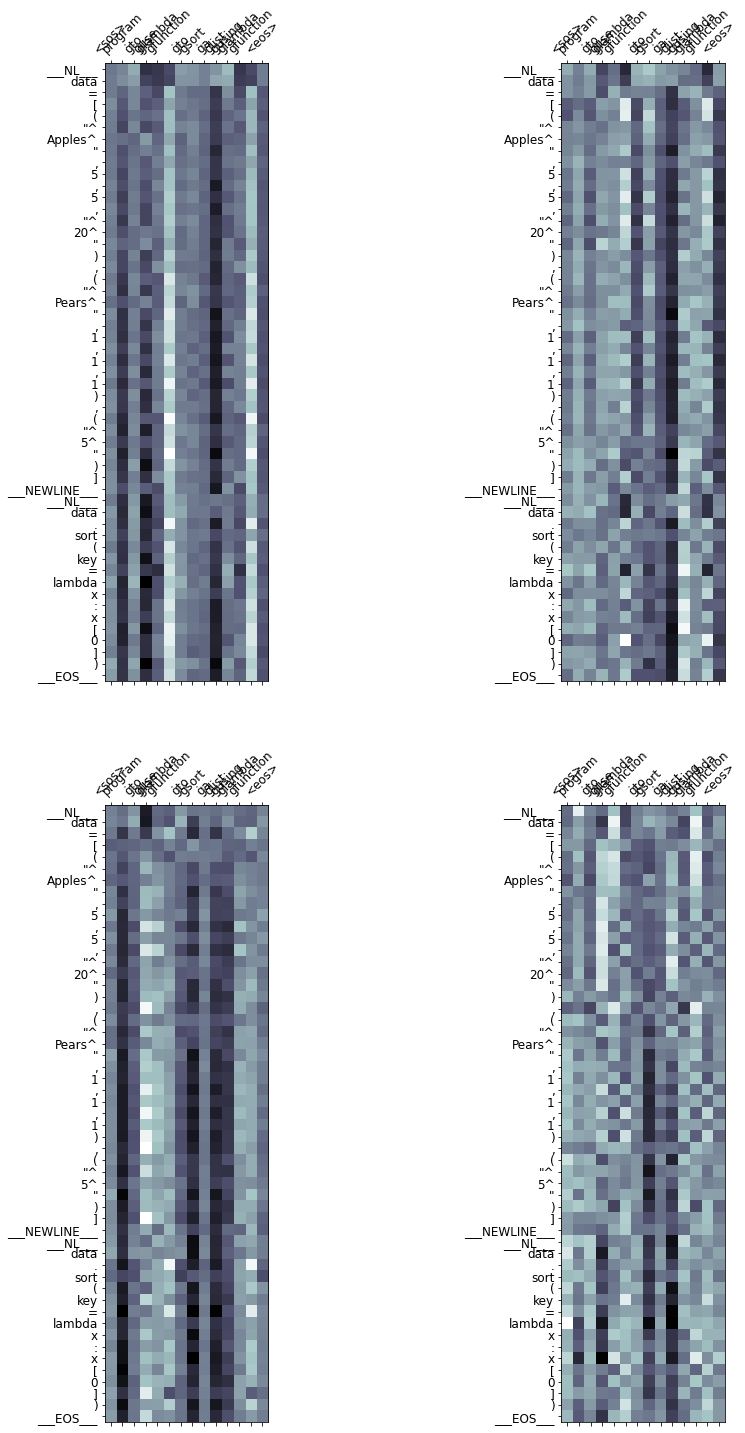

In [264]:
import matplotlib.ticker as ticker

#display_attention(splitted_text, mycode, attention_val[:,2,:,:].unsqueeze(1), n_heads=1, n_rows=1, n_cols=1)
n_heads=4
n_rows=2
n_cols=n_heads/n_rows
display_attention(splitted_text, 
                  mycode, 
                  attention_val[:,:8,:,:], 
                  n_heads=n_heads, 
                  n_rows=n_rows, 
                  n_cols=n_cols)


In [ ]:
!cp /content/end_capstone_self_encode_sizeCor.pt /content/drive/MyDrive/EVA4/END_Capstone

In [ ]:
str1 ='It is a glorious day'

res =len (str1 .split ())

print ("The number of words in string are : "+str (res ))

The number of words in string are : 5


In [ ]:
nl_to_pl_df[(nl_to_pl_df['cleaned_code_len'] <= 128) & (nl_to_pl_df['docstring_len'] <= 256)].count()

docstring           2675
code                2675
docstring_len       2675
code_len            2675
cleaned_code        2675
cleaned_code_len    2675
dtype: int64

In [ ]:
all_strings = nl_to_pl_df[nl_to_pl_df['cleaned_code_len'] <= 128]['cleaned_code'].values

for one_string in all_strings[2700:2750]:
    print(one_string)

In [ ]:
#all_strings = nl_to_pl_df[(nl_to_pl_df['cleaned_code_len'] <= 128) & (nl_to_pl_df['docstring_len'] <= 256)]['docstring'].values
all_strings = nl_to_pl_df[(nl_to_pl_df['cleaned_code_len'] <= 256) ]['docstring'].values

gen_code_arr = []
for one_string in all_strings:
    #splitted_text = auto_tokenizer.tokenize(input_text)
    gen_code = "NoCode"
    cleaned_string = one_string.rstrip('\n').lstrip('#')
    try:
        mycode, my_tok, attention_val = get_code(cleaned_string,
                                        auto_tokenizer, 
                                        init_tokenizer,
                                        code_tok_vectorizer,
                                        model, 
                                        device,
                                        max_len=200)
        gen_code = init_tokenizer.untokenize(mycode)
        gen_code_arr.append(gen_code)
    except:
        print("Error")        
        print(cleaned_string)
        gen_code_arr.append(gen_code)
        continue

In [216]:
nl_to_pl_df.loc[(nl_to_pl_df['cleaned_code_len'] <= 256), 'gen_code'] = gen_code_arr

In [282]:
nl_to_pl_df.to_csv("end_capstone_gen_code.csv", index=False)

In [220]:
all_strings = nl_to_pl_df[(nl_to_pl_df['cleaned_code_len'] <= 256) ][['docstring','cleaned_code', 'gen_code']]

In [224]:
for row in all_strings[-50:].itertuples():
    print("*****************START****************************")
    print(row.docstring)
    print(row.cleaned_code)
    print("*********************************************")
    print(row.gen_code)
    print("*******************END**************************")
    #print(row.gen_code)

*****************START****************************
# By using list comprehension, write a program to print the list after removing the 0th, 2nd, 4th,6th numbers in [12,24,35,70,88,120,155].

li = [12,24,35,70,88,120,155]
li = [x for (i,x) in enumerate(li) if i%2!=0]
print li
*********************************************
li =[12 ,24 ,35 ,70 ,88 ,120 ,155 ]
li =[x for (i ,x )in enumerate (li )if i %2 !=0 ]
print li 
*******************END**************************
*****************START****************************
# By using list comprehension, write a program generate a 3*5*8 3D array whose each element is 0.

array = [[ [0 for col in range(8)] for col in range(5)] for row in range(3)]
print array
*********************************************
array =[[[0 for col in range (8 )]for col in range (8 )]for row in range (3 )]
print array 
*******************END**************************
*****************START****************************
# By using list comprehension, write a program to print 

In [225]:
limit =0 

while (c >0 ):
    a =b 
    c =b =b 
    c =a +c 
    if (b >a else b %c ==0 ):
        if (a ==0 ):
            break 
    if (a ==0 ):
        break 
    else :
        print ("LCM is:",min1 )

SyntaxError: ignored

In [ ]:
mean_key_val_diff({1:2, 3:4})

TypeError: ignored

In [ ]:
all_strings = nl_to_pl_df['docstring'].values
for one_string in all_strings[100:149]:
    cleaned_string = one_string.rstrip('\n').lstrip('#')
    mycode, attention_val = get_code(cleaned_string,auto_tokenizer, model, device, max_len=512)
    print(cleaned_string)
    print(auto_tokenizer.convert_tokens_to_string(mycode[:-1]))


TypeError: ignored

In [ ]:
def even_odd_num(num):
    max = 0
    for num in num:
         if num % 10 == 0:
                 maxnum = num
         return maxnum

In [ ]:
even_odd_num(2)

In [ ]:
torch.save({"model":model.state_dict(),
            "optimizer":optimizer.state_dict(),
            "loss":1.373
            },'end_capstone_baseline_128.pt')

In [ ]:
n = int(input("How many terms? "))

n1 = 0

for i in range(n+1):
    result = 0
    for i in range(n2, n+1):
        result = result + result*n2
    print(result)

In [ ]:
!cp /content/end_capstone_baseline_128.pt /content/drive/MyDrive/EVA4/END_Capstone

In [ ]:
a = [1, 2, 3, 4, 5]
b = [5, 6, 7, 8]
a.update(b)
print(a)

In [ ]:
a = {1, 2, 3}
b = {3, 4, 5, 6}
a = {1, 2, 2, 3, 4}
x = a[i]*b for (a, b) in zip(a, b) )
print(f"{a}")

In [ ]:
def printSubArrays(arr, start, end):
    if end == len(arr):
        return
    elif start > end:
        return printSubArrays(arr, 0, end + 1)
    else:
            print(arr[start:end + 1])